In [1]:
def parse_output(heatmap_data,offset_data, threshold):

  joint_num = heatmap_data.shape[-1]
  pose_kps = np.zeros((joint_num,3), np.uint32)

  for i in range(heatmap_data.shape[-1]):

      joint_heatmap = heatmap_data[...,i]
      max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap)))
      remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
      pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
      pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
      max_prob = np.max(joint_heatmap)

      if max_prob > threshold:
        if pose_kps[i,0] < 257 and pose_kps[i,1] < 257:
          pose_kps[i,2] = 1

  return pose_kps

In [2]:
def draw_kps(show_img,kps, ratio=None):
    for i in range(5,kps.shape[0]):
      if kps[i,2]:
        if isinstance(ratio, tuple):
          cv.circle(show_img,(int(round(kps[i,1]*ratio[1])),int(round(kps[i,0]*ratio[0]))),2,(0,255,255),round(int(1*ratio[1])))
          continue
        cv.circle(show_img,(kps[i,1],kps[i,0]),2,(0,255,255),-1)
        cv2_imshow(show_img)
    return show_img

In [3]:
#loop
def draw_deviations(img, keypoints, pairs):
  for i, pair in enumerate(pairs):
    color = (0,255,255)
    cv.line(img, (keypoints[pair[0]][1], keypoints[pair[0]][0]), (keypoints[pair[1]][1], keypoints[pair[1]][0]), color=color, lineType=cv.LINE_AA, thickness=1)
  return img

In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import cv2 as cv
#from google.colab.patches import cv2_imshow
import math
model_path = "posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"



def get_keypoints(template_path):


  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  im = Image.fromarray(template_path)
  #dst ="Hostel" + str(i) + ".jpg"
  im.save("filename"+str(i)+".jpeg")

  template_path="filename"+str(i)+".jpeg"
  template_image_src =cv.imread(template_path) 

  template_image = cv.resize(template_image_src, (width, height))
  template_input = np.expand_dims(template_image.copy(), axis=0)
  
  floating_model = input_details[0]['dtype'] == np.float32
 
  if floating_model:
    template_input = (np.float32(template_input) - 127.5) / 127.5

  interpreter.set_tensor(input_details[0]['index'], template_input)

  interpreter.invoke()
 
  template_output_data = interpreter.get_tensor(output_details[0]['index'])
  template_offset_data = interpreter.get_tensor(output_details[1]['index'])
 
  template_heatmaps = np.squeeze(template_output_data)
  template_offsets = np.squeeze(template_offset_data)

  template_show = np.squeeze((template_input.copy()*127.5+127.5)/255.0)
  template_show = np.array(template_show*255,np.uint8)
  keypoints = parse_output(template_heatmaps,template_offsets,0.3)
  #print(keypoints)
  

  return template_show,keypoints,height,width

In [5]:
def draw_skeleton(img, keypoints):
  pairs = [(5,6),(5,7),(6,8),(7,9),(8,10),(11,12),(5,11),(6,12),(11,13),(12,14),(13,15),(14,16)]
  
  for i, pair in enumerate(pairs):
    color = (0,255,255)
    cv.line(img, (keypoints[pair[0]][1], keypoints[pair[0]][0]), (keypoints[pair[1]][1], keypoints[pair[1]][0]), color=color, lineType=cv.LINE_AA, thickness=1)

  max_x=max(keypoints[i][0] for i in range(0,len(keypoints)))
  max_y=max(keypoints[i][1]for i in range(0,len(keypoints)))
  min_x=min(keypoints[i][0]for i in range(0,len(keypoints)))
  #print(keypoints,keypoints[pair[0]][1])
  min_y=min(keypoints[i][1]for i in range(0,len(keypoints)))  

  #print('MIN_X =',min_x)
  #print('MIN_y =',min_y)
  #print('Max_X =',max_x)
  #print('Max_y =',max_y)
 

  w=max_x-min_x
  h=max_y-min_y
  #print('W,H RECTANGLE=',w,h)
  cv.rectangle(img, ( min_y,min_x),( min_y + h,min_x + w,),(0, 0, 255), 2)
  return img,w,h

In [7]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


Processing Video...
Timeframe= 2


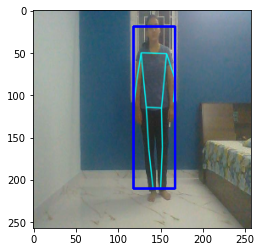

Timeframe= 4


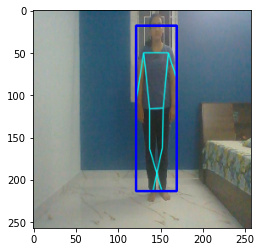

Timeframe= 6


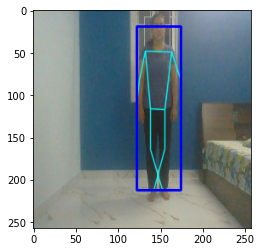

Timeframe= 8


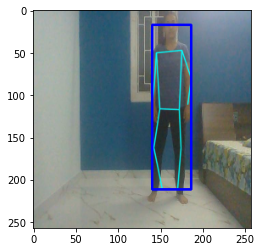

Timeframe= 10


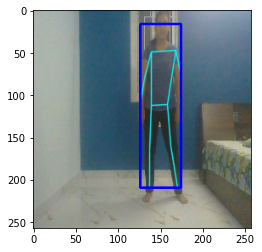

Timeframe= 12


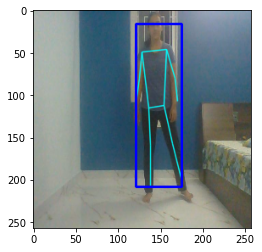

Timeframe= 14


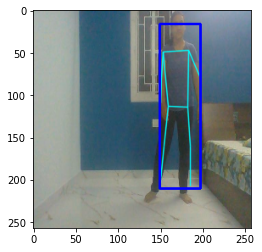

Timeframe= 16


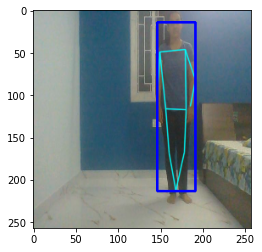

Timeframe= 18


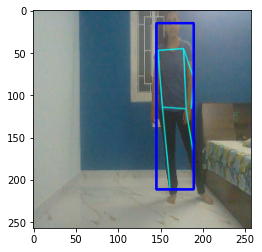

Timeframe= 20


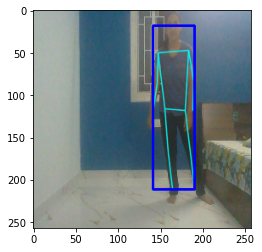

Timeframe= 22


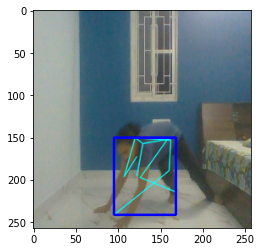

Timeframe= 24


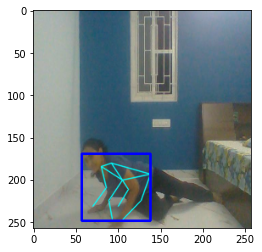

FALL DETECTED


SystemExit: 1

In [24]:
#TESTING A FRAME OF VIDEO

import cv2
import sys
import matplotlib.pyplot as plt
#cap = cv2.VideoCapture('fall.mp4')
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
#out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")


hip=[]
head=[]
foot=[]
bound_box=[]
i=0
count=0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        #out.release()
        break
    
    i=i+1
    template_show,template_kps,height,width=get_keypoints(frame)
    out_frame,h,w=draw_skeleton(template_show, template_kps)
    
    max_x=max(template_kps[i][0] for i in range(0,len(template_kps)))
    max_y=max(template_kps[i][1]for i in range(0,len(template_kps)))
    min_x=min(template_kps[i][0]for i in range(0,len(template_kps)))
    #print(keypoints,keypoints[pair[0]][1])
    min_y=min(template_kps[i][1]for i in range(0,len(template_kps))) 
    #print('MIN_y =',min_x)
    #print('MIN_x =',min_y)
    #print('Max_y =',max_x)
    #print('Max_x =',max_y)
    hi=max_x-min_x
    wi=max_y-min_y
    #print('w=',wi,' h=',hi)
    #ratio=w/h
    if(hi>=wi):state=1
    else:state=-1
    #print('STATE,W,H=',state,w,h)
    #bound_box.append([i,ratio,state,w,h])
    i=i+1
    print('Timeframe=',i)
    plt.imshow(out_frame)
    plt.show()
    
    if(state==-1):
        print('FALL DETECTED')
        sys.exit(1)
        
        
    '''out_frame,h,w=draw_skeleton(template_show, template_kps)
    plt.imshow(out_frame)
    plt.show()'''
    
    
  


In [9]:
print('NO OF FRAMES', count)
fall=0
vel_angle=[]
for i in range(0,len(hip)-3):
    
    if fall==1:break
        
    #print('i=',i)
    #cv2_imshow("filename"+str(i)+".jpeg")
    counter=[]
    #print('in11')
    if((i+5)>=len(hip)):break
    #print('in222')
    v=(abs(hip[i+3][1]-hip[i][1])/3)   #1. VELOCITY
    #tita=np.degrees(math.atan(abs((head[i][2]-foot[i][2])/(head[i][1]-foot[i][1]))))  #2. ANGLE


    a = np.array([head[i][1],head[i][2]])
    b = np.array([foot[i][1],foot[i][2]])
    c = np.array([head[i+3][1],head[i+3][2]])

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    #print()
    vel_angle.append([hip[i][0],v,np.degrees(angle)])    
    
    #print()
    #print('Timeframe=',hip[i][0])
    #print('v=',v)
    #print('angle=',np.degrees(angle))


        #print('y[',i,'][0]','t1=',y3[i][0] ,' t2=',y3[i+5][0])
        #print('t1=',y3[i][0] ,' t2=',y3[i+5][0])
        #print('y1=',y3[i][1],'  y2=',y3[i+5][1])

        #print('tita=',tita)
 
    if (v > 25 and np.degrees(angle)>50 or bound_box[i][2]==-1):#and 
        #print('v=',v)
        fall=1
        print('FALL angle=',np.degrees(angle))
        print("FALL DETECTED AT :",hip[i][0])
        stood=0
                
        if bound_box[i][1]>1:
            print('BOUNDING BOX')
            print('State,w,h=',bound_box[i][2],bound_box[i][3],bound_box[i][4])
            stood=0
            #fall=1
            box=0
            if i+30>len(hip):l=len(hip)
            else: l=i+30
            for j in range(i,l):
                if bound_box[j][1]<1:
                    box=box+1
            if box>24:
                stood=1
        else:    
            print('SPEED')
            for j in range(i+10,i+20):
                #print('j=',j)
                a = np.array([head[j][1],head[j][2]])
                b = np.array([foot[j][1],foot[j][2]])
                c = np.array([head[j+3][1],head[j+3][2]])

                ba = a - b
                bc = c - b

                cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
                angle2 = np.arccos(cosine_angle)


                #print('angle2=',np.degrees(angle2))
                if (np.degrees(angle2)>10):
                    print('ANGLE STOOD UP AT:',np.degrees(angle2))
                    print("PERSON HAS STOOD UP",hip[j][0])
                    stood=1
                    break

        


if fall==0: print(' No fall ')
elif stood==0:print("PERSON HAS NOT STOOD UP",hip[i][0])
else :print("PERSON HAS STOOD UP",hip[i][0])
    #break;
  #out.write(out_frame)
#out.release()
print("Done processing video")

NO OF FRAMES 0
 No fall 
Done processing video


In [13]:
len(bound_box)

94